#### Kelompok 8
1. 12S21011 - Aldi Jeremy Simamora
2. 12S21034 - Lasni Sinta Uli Simanjuntak
3. 12S21036 - Astri Yuliana Siahaan

# Item-Based Collaborative Filtering

# Data Preparation

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
df = pd.read_csv('Tempat-Wisata-Toba-Preprocessing.csv')

In [4]:
# Cek struktur dataset
print(df.head())

   Unnamed: 0.1  Unnamed: 0  \
0             0           0   
1             1           1   
2             2           2   
3             3           3   
4             4           4   

                                             address  PlaceID  \
0  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
1  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
2  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
3  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   
4  Jl. Sibola Hotang, Sibola Hotangsas, Kec. Bali...        0   

          Nama_tempat_wisata       Category    ReviewerId  Rating  \
0  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.126030e+20     5.0   
1  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.119090e+20     5.0   
2  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.078860e+20     5.0   
3  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.130720e+20     5.0   
4  PASIR PUTIH LUMBAN BULBUL  Wisata Bahari  1.061730e+20     5.0   

       

Mempersiapkan dataset dengan memilih hanya kolom yang relevan, yaitu ReviewerId, PlaceID, dan Rating, kemudian menghapus baris yang memiliki nilai kosong menggunakan dropna(). Setelah itu, tipe data untuk kolom ReviewerId dan PlaceID diubah menjadi integer, sementara kolom Rating diubah menjadi tipe float untuk memastikan kesesuaian format data dengan analisis selanjutnya. Proses ini memastikan bahwa data yang digunakan bersih, lengkap, dan dalam format yang tepat untuk diproses lebih lanjut dalam model rekomendasi.

In [5]:
# Preprocessing the data: keep only relevant columns and drop rows with missing values
cleaned_data = df[['ReviewerId', 'PlaceID', 'Rating']].dropna()
cleaned_data['ReviewerId'] = cleaned_data['ReviewerId'].astype(int)
cleaned_data['PlaceID'] = cleaned_data['PlaceID'].astype(int)
cleaned_data['Rating'] = cleaned_data['Rating'].astype(float)

In [6]:
# Map user and place IDs to indices for the matrix
user_mapping = {user_id: idx for idx, user_id in enumerate(cleaned_data['ReviewerId'].unique())}
place_mapping = {place_id: idx for idx, place_id in enumerate(cleaned_data['PlaceID'].unique())}

cleaned_data['user_index'] = cleaned_data['ReviewerId'].map(user_mapping)
cleaned_data['place_index'] = cleaned_data['PlaceID'].map(place_mapping)

In [7]:
# Create user-item interaction matrix
num_users = len(user_mapping)
num_places = len(place_mapping)
interaction_matrix = np.zeros((num_users, num_places))

for _, row in cleaned_data.iterrows():
    interaction_matrix[int(row['user_index']), int(row['place_index'])] = row['Rating']

In [8]:
# Membagi dataset menjadi train (70%), validation (15%), dan test (15%)
# Convert the interaction_matrix to a DataFrame first
pivot_df = pd.DataFrame(interaction_matrix)
# reset index for user and item
pivot_df = pivot_df.reset_index().rename(columns={'index':'user_index'})
pivot_df = pivot_df.melt(id_vars='user_index',var_name='place_index', value_name='Rating')
# cast index to int
pivot_df['place_index'] = pivot_df['place_index'].astype(int)
# filter zero rating data
pivot_df = pivot_df[pivot_df['Rating']>0]

train_df, temp_df = train_test_split(pivot_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## Pearson Correlation

In [9]:
# Function to compute Pearson Correlation similarity matrix for items (places)
def compute_pearson_similarity(interaction_matrix):
    # Normalize the interaction matrix by subtracting the mean rating per user
    user_means = np.mean(interaction_matrix, axis=1)
    interaction_matrix_normalized = interaction_matrix - user_means[:, np.newaxis]

    # Compute the Pearson correlation matrix between items (places)
    # Transpose to calculate item-item similarity
    similarity_matrix = np.corrcoef(interaction_matrix_normalized.T)

    # Handling NaN values (if there is no variation in ratings for an item)
    similarity_matrix = np.nan_to_num(similarity_matrix)  # Convert NaNs to 0

    # Ensure that diagonal values are set to 0 (no similarity with itself)
    np.fill_diagonal(similarity_matrix, 0)

    return similarity_matrix

In [10]:
# Compute similarity matrix using Pearson Correlation
similarity_matrix = compute_pearson_similarity(interaction_matrix)

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [11]:
# Function to recommend items based on similarity (IBCF)
def recommend_items(user_index, top_n=10):
    # Get the user's ratings
    user_ratings = interaction_matrix[user_index]

    # Calculate predicted ratings for all items (places)
    predicted_ratings = similarity_matrix.dot(user_ratings) / np.array([np.abs(similarity_matrix).sum(axis=1)])

    # Sort items by predicted rating (highest to lowest)
    top_items = np.argsort(predicted_ratings)[::-1][:top_n]

    return top_items

In [12]:
# Function to evaluate model using RMSE, MAE, Precision, Recall, and MAP
def evaluate_model(test_data, similarity_matrix, top_n=10):
    y_true = []
    y_pred = []

    for _, row in test_data.iterrows():
        user_index = int(row['user_index'])
        place_index = int(row['place_index'])
        true_rating = row['Rating']

        # Get the top N recommendations for the user
        recommended_items = recommend_items(user_index, top_n=top_n)

        if place_index in recommended_items:
            y_true.append(1)  # True positive (relevant item)
        else:
            y_true.append(0)  # False negative (non-relevant item)

        # We append the true rating as prediction for evaluation
        y_pred.append(true_rating)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Precision, Recall, MAP for ranking-based evaluation
    # Changed the average from 'binary' to 'micro', 'macro', or 'weighted' for multiclass
    precision = precision_score(y_true, y_pred, average='micro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='micro', zero_division=1)
    map_score = average_precision_score(y_true, y_pred)

    return rmse, mae, precision, recall, map_score

In [13]:
# Evaluate for Top 5 and Top 10 recommendations
rmse_5, mae_5, precision_5, recall_5, map_5 = evaluate_model(test_df, similarity_matrix, top_n=5) # Changed test_data to test_df
rmse_10, mae_10, precision_10, recall_10, map_10 = evaluate_model(test_df, similarity_matrix, top_n=10) # Changed test_data to test_df

C:\Users\User\AppData\Local\Temp\ipykernel_18748\2880543351.py:7: RuntimeWarning: invalid value encountered in true_divide
  predicted_ratings = similarity_matrix.dot(user_ratings) / np.array([np.abs(similarity_matrix).sum(axis=1)])
C:\Users\User\AppData\Local\Temp\ipykernel_18748\2880543351.py:7: RuntimeWarning: invalid value encountered in true_divide
  predicted_ratings = similarity_matrix.dot(user_ratings) / np.array([np.abs(similarity_matrix).sum(axis=1)])


In [14]:
# Display the results in a DataFrame
results = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Precision@5', 'Recall@5', 'MAP@5', 'Precision@10', 'Recall@10', 'MAP@10'],
    'Score': [rmse_5, mae_5, precision_5, recall_5, map_5, precision_10, recall_10, map_10]
})

print(results)


         Metric     Score
0          RMSE  3.230712
1           MAE  2.937500
2   Precision@5  0.125000
3      Recall@5  0.125000
4         MAP@5  1.000000
5  Precision@10  0.125000
6     Recall@10  0.125000
7        MAP@10  1.000000


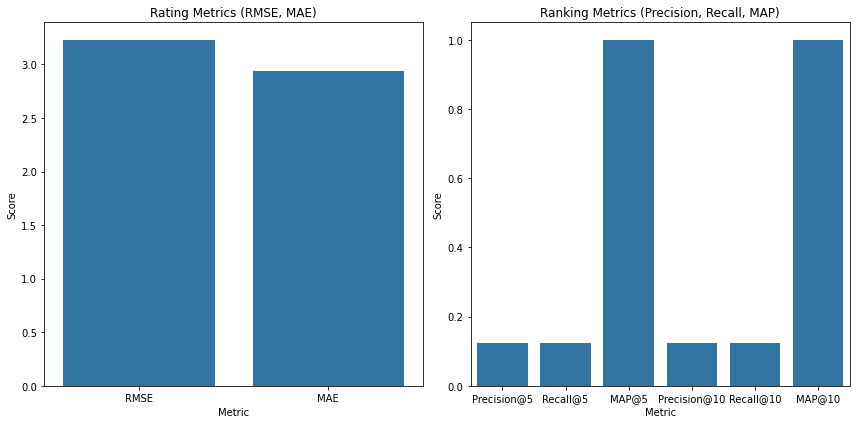

In [15]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x='Metric', y='Score', data=results.loc[results['Metric'].isin(['RMSE', 'MAE'])], ax=ax[0])
ax[0].set_title('Rating Metrics (RMSE, MAE)')
sns.barplot(x='Metric', y='Score', data=results.loc[results['Metric'].isin(['Precision@5', 'Recall@5', 'MAP@5', 'Precision@10', 'Recall@10', 'MAP@10'])], ax=ax[1])
ax[1].set_title('Ranking Metrics (Precision, Recall, MAP)')
plt.tight_layout()
plt.show()